In [1]:
%matplotlib inline
import numpy as np
from  minimulti.electron.Hamiltonian import etb_model, atoms_model
from minimulti.electron.epc import EPC
from minimulti.electron.basis2 import BasisSet, gen_basis_set, atoms_to_basis
from ase.atoms import Atoms
import matplotlib.pyplot as plt


def plot_epc(t=1,  dtdx=0.1, dx=0.0, nel=1, U=4, spinat=[1,1]):
    # generate structure.
    atoms=Atoms(symbols='H', positions=[(0,0,0)], cell=[1,1,1])
    # generate basis set
    bset= atoms_to_basis(atoms, basis_dict={'H': ('s',)}, nspin=2)
    # generate model
    mymodel=atoms_model(atoms=atoms, basis_set=bset, nspin=2)

    # make supercell
    sc_matrix=np.diag([1,1,2])
    nsc=np.linalg.det(sc_matrix)
    mymodel=mymodel.make_supercell(sc_matrix)
    # onsite energy (tune v to make electron localized on one site)
    # mymodel.set_onsite(v,0)
    # mymodel.set_onsite(v,1)

    # 1D hopping along z. Format: t, i, j, R.
    # spin up
    mymodel.set_hop(t-dtdx*dx, 0,2, [0,0,0])
    mymodel.set_hop(t+dtdx*dx, 2,0,[0,0,1])
    # spin down
    mymodel.set_hop(t-dtdx*dx, 1,3, [0,0,0])
    mymodel.set_hop(t+dtdx*dx, 3,1, [0,0,1])
    mymodel.set(nel=nel*nsc, mixing=0.5, tol_energy=1e-8, tol_rho=1e-8, sigma=0.1)
    mymodel.set_Hubbard_U(Utype='Dudarev', Hubbard_dict={'H':{'U':U, 'J':0}})
    mymodel.set_initial_spin(spinat)
    # K mesh.
    mymodel.set_kmesh([1,1,30])

    # Scf solve
    mymodel.scf_solve(print_iter_info=False)
    efermi=mymodel.get_fermi_level()
    
    # Electron phonon coupling term.
    epc_nospin=EPC(norb=2)
    epc_nospin.add_term(R=(0,0,0), i=0, j=1,val=-dtdx)
    epc_nospin.add_term(R=(0,0,1), i=1, j=0,val=dtdx)
    #epc_nospin.add_term(R=(0,0,0), i=0, j=1,val=dt)
    #epc_nospin.add_term(R=(0,0,0), i=0, j=1,val=dt)
    epc_spin=epc_nospin.to_spin_polarized()

    #shift=epc_spin.get_band_shift(kpts, evecs, mymodel.bset.get_positions())
    #print(shift)
    #print(epc_spin._epc)
    
    kpt_x=np.arange(0, 1.01,0.01)
    kpts=[np.array([0,0,1]) * x for x in kpt_x]
    evalues, evecs=mymodel.solve_all(k_list=kpts)

    ax=epc_spin.plot_epc_fatband(kpts, evalues, evecs,  kpt_x, X=[0,1], xnames=['0','1'], show=False, efermi=efermi, width=3)
    for i in range(mymodel._norb):
        ax.plot(kpt_x, evalues[i,:], color='green', linewidth=0.1)
    ax.set_xlabel('k-point')
    ax.set_ylabel('Energy')
    ax.axhline(efermi, linestyle='--', color='gray')

    plt.show()
    

/Users/hexu/projects/minimulti/minimulti/electron/epc.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[:, ik] = Pert.Epert1(evecs_ik, Hk)


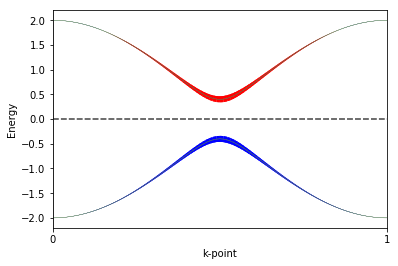

In [2]:
plot_epc(dx=0.2, dtdx=1,U=5, spinat=[0,0])

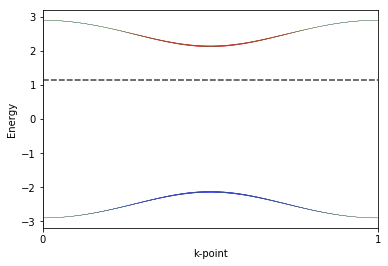

In [3]:
plot_epc(dx=0.2, dtdx=1,U=5, spinat=[1,-1])

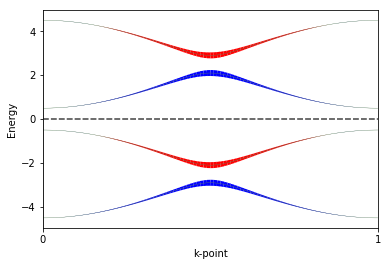

In [4]:
plot_epc(dx=0.2, dtdx=1,U=5, spinat=[1,1])